# Feature Impute and Train

## Summary:

Below are the predictions for 3yr cumulative oil recovery.

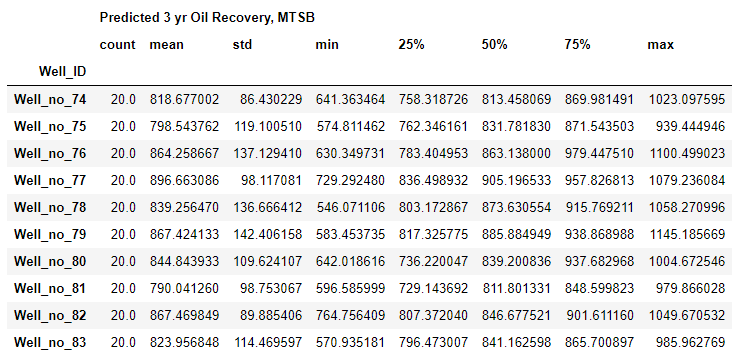




We model oil recovery using an artificial neural network that considers the petrophysical properties of the wellbore, measured at each depth. Using our ANN, we predict the oil recovery at each depth interval, and aggregate these predictions to produce the mean oil recovery per well. The following outline the advantages of this approach:  

Predictions scale with well depth and new information. That is, there is no need to retrain the model if additional well log data comes is added, because the model outputs incremental recovery predictions for every new data point.

Predictions have less uncertainty, because there is no upscaling. Users can predict depth-dependent recovery estimates, and identify depth intervals of high production.

We choose the following depth-dependent numerical attributes as predictor features: Porosity, fraction	Permeability, mD	Acoustic Impedance, kg*s/m^2	Density, g/cm3	Compressible velocity, m/s	Youngs modulus, GPa	Shear velocity, m/s	Shear modulus, GPa.  

Label: Petrophysics-dependent cumulative oil recovery, MTSB, predicted for each depth and for each well.  

### Training Steps

We package feature and label transformations into pipelines, which sequentially perform the fit_transform method for each transformation.

For predictor features, we:  
Drop non predictor features from the input,  
Standardize all predictor features,    
Perform KNearestNeighbors with 8 neighbors,  
Normalize to 0-1 (minmax).   
 
For labels,  
Perform log transormation,    
Normalize to 0-1.    

ANN hyperparameters:  2 layers, 10 nodes each, 100 epochs.  

### Hyperparameter Choice Justification

Features selected by domain expertise. From data exploration, we saw that permeability values are very sparse, but highly predictive for cumulative oil production. Remaining features had abou 5-15% of values missing.  

Feature standardization is necessary for distance-based estimators, in this case KNN.  
Iterative imputation with KNN appeared a feasible solution to fill missing values. We tested 1-20 neighbors in 5-fold cross-validation scores evaluated by bayesian ridge.  

Next, the we perform PCA to reduce dimensionality, as higher dimensional data is harder to fit to a model. We test 1-8 dimensions, and found selected 4 dimensions and found that they were a good balance of explaine variance (93%) and few dimensions.  

We normalize to 0-1 to help train the ANN. The activation function, Leaky ReLU, may converge faster for strictly positive training data.  


For labels, the cumulative oil production at 3 years, we noticed the histogram distribution to be logarithmic. Therefore, we perform a log-transform to make the distribution symmetric, and roughly bell-shaped. This helps the model training.  

Then, we perform min-max normalization to 0-1.  


Lastly, we chose 2 layers, 10 nodes per layer, and trained for 100 epochs.  
We keep only 2 layers to reduce model variance, following the advice of the mentor Nkem.  

In [1]:
# Import all the good stuff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


import tensorflow as tf

import os
import pandas as pd
import tensorflow as tf
import subprocess
import pickle
import datetime
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer


In [2]:
# Read producer
prod = pd.read_csv("https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/wellbore_data_producer_wells.csv?token=AN5MCLBHM2IYJT6OO42JN43AQDE4U")
# Read cumulative oil
cumoil = pd.read_csv('https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/production_history.csv?token=AN5MCLGECACCOYCJDAQCPYTAQDFCE')

In [58]:
# Join on Well_ID (Left outer join)
df = pd.merge(prod, cumoil, on='Well_ID',how='left')
df.head()


,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa","Cumulative oil production (1 yr), MSTB","Cumulative oil production (2 yr), MSTB","Cumulative oil production (3 yr), MSTB","Cumulative Water production (1 yr), MSTB","Cumulative Water production (2 yr), MSTB","Cumulative Water production (3 yr), MSTB"
0,Well_no_1,7325,7175,3052.8,0.13330,NaN,6981171.853,Sandstone,2.280137,3106.544655,24.721555,1690.417133,7.304717,450.98,684.2,847.33,494.89,1236.4,2108.7
1,Well_no_1,7325,7175,3053.3,0.13865,NaN,7234748.871,Sandstone,2.135061,4003.697087,23.360728,1573.847967,5.202120,450.98,684.2,847.33,494.89,1236.4,2108.7
2,Well_no_1,7325,7175,3053.8,0.14638,NaN,7157383.755,Sandstone,1.991045,3462.569030,28.232152,1636.279139,NaN,450.98,684.2,847.33,494.89,1236.4,2108.7
3,Well_no_1,7325,7175,3054.3,NaN,NaN,NaN,Sandstone,1.694242,3836.960702,29.220132,1613.043048,5.074763,450.98,684.2,847.33,494.89,1236.4,2108.7
4,Well_no_1,7325,7175,3054.8,0.14993,NaN,NaN,Sandstone,1.664371,3919.585777,NaN,1636.846284,5.277834,450.98,684.2,847.33,494.89,1236.4,2108.7


In [4]:
# Select the relevant attributes (columns) to impute
X = df.iloc[:,4:13].copy()
X.drop(['Rock facies'],axis=1,inplace=True)
X_coln = X.columns
X.head()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,0.13330,NaN,6981171.853,2.280137,3106.544655,24.721555,1690.417133,7.304717
1,0.13865,NaN,7234748.871,2.135061,4003.697087,23.360728,1573.847967,5.202120
2,0.14638,NaN,7157383.755,1.991045,3462.569030,28.232152,1636.279139,NaN
3,NaN,NaN,NaN,1.694242,3836.960702,29.220132,1613.043048,5.074763
4,0.14993,NaN,NaN,1.664371,3919.585777,NaN,1636.846284,5.277834


<AxesSubplot:>

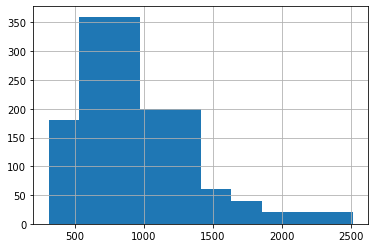

In [5]:
# Select label, the 3-year cumulative oil prod
y = df.loc[:,'Cumulative oil production (3 yr), MSTB'].copy()
y_name = y.name
y.hist()

<AxesSubplot:>

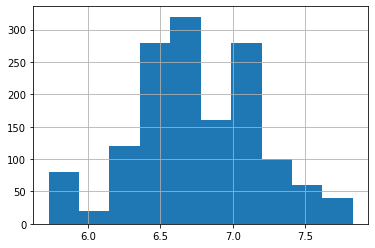

In [6]:
# After log transform
y_log = np.log(y)
y_log.hist()

In [7]:
# Standardize labels and features before KNN imputation
std_scaler_X = StandardScaler()
std_scaler_y = StandardScaler()
X_std = std_scaler_X.fit_transform(X)
y_std = std_scaler_y.fit_transform(np.array(y).reshape(-1,1))

In [8]:
# Check the features
X.head()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,0.13330,NaN,6981171.853,2.280137,3106.544655,24.721555,1690.417133,7.304717
1,0.13865,NaN,7234748.871,2.135061,4003.697087,23.360728,1573.847967,5.202120
2,0.14638,NaN,7157383.755,1.991045,3462.569030,28.232152,1636.279139,NaN
3,NaN,NaN,NaN,1.694242,3836.960702,29.220132,1613.043048,5.074763
4,0.14993,NaN,NaN,1.664371,3919.585777,NaN,1636.846284,5.277834


In [9]:
# Search best n_neighbours value (hyperparameter search) for KNN
# Apply KNN iteratively
# Score on BaysianRidge
br_estimator = BayesianRidge()

# Cross validate with 5 splits
N_SPLITS=5

# Define the estimators
estimators = [
    KNeighborsRegressor(n_neighbors=i) for i in range(1,20)
]

# Get scores form each imputation method
score_iterative_imputer=pd.DataFrame().copy()
for impute_estimator,i in zip(estimators,range(len(estimators))):
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer['n={}'.format(i+1)] = \
        cross_val_score(
            estimator, X_std, y_std, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

In [10]:
# 8 neighbours best score
score_iterative_imputer.mean(axis=0)

n=1    -0.933301
n=2    -0.912331
n=3    -0.909894
n=4    -0.907658
n=5    -0.906602
n=6    -0.909198
n=7    -0.903095
n=8    -0.902952
n=9    -0.906996
n=10   -0.906969
n=11   -0.906369
n=12   -0.907642
n=13   -0.907794
n=14   -0.909170
n=15   -0.910414
n=16   -0.910561
n=17   -0.910150
n=18   -0.908443
n=19   -0.908649
dtype: float64

In [57]:
# Check if iterative imputer works
imp = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(n_neighbors=8))
X_full_std =imp.fit_transform(X_std,y_std)
# Inverse standardize to get actual values
X_full = std_scaler_X.inverse_transform(X_full_std)
# Restore column names
X_full = pd.DataFrame(X_full, columns=X_coln)
# Display
X_full.head()
# Save
X_full.to_csv('imputed_values.csv',index=False)

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [84]:
# (Unrelated) Add facies colum for export
temp=X_full.copy()
temp['Rock facies']=df['Rock facies']
temp['Well_ID']=df['Well_ID']
temp.to_csv('imputed_values_plus_facies_wellID.csv',index=False)

In [12]:
# Sanity check on X_full: No impossible values (Ex: Negatives). Verify all missing values filled.
X_full.describe()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,1460.000000,1460.000000,1.460000e+03,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.128199,108.997465,7.322775e+06,2.042147,3697.712144,27.311022,1675.223964,5.752435
std,0.035387,59.517569,3.058621e+05,0.412723,718.741864,5.414508,95.085676,1.483936
min,0.040270,2.214604,6.559277e+06,1.421943,1661.828496,13.205134,1307.887097,1.650985
25%,0.117070,63.786453,7.114410e+06,1.728960,3189.904778,23.442919,1615.680398,4.777528
50%,0.138020,104.356596,7.270281e+06,1.975040,3673.863629,26.756913,1674.110346,5.599665
75%,0.151885,138.299071,7.482806e+06,2.212782,4212.620158,30.928539,1735.942264,6.541508
max,0.188910,489.219402,8.249272e+06,3.530373,6179.653016,48.123292,1989.829247,11.820038


In [13]:
# Compare to original features, mean and std remain same.
X_full.describe()-X.describe()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,192.000000,1.176000e+03,103.000000,212.000000,184.000000,1.990000e+02,190.000000,1.750000e+02
mean,0.000454,-3.185274e+00,-3010.760558,-0.010373,9.054291,2.214487e-02,-0.934111,-2.046664e-04
std,-0.000633,-2.137687e+01,-4250.478932,-0.004899,-8.474374,-1.010056e-02,-5.544418,-3.476305e-02
min,0.000000,4.440892e-16,0.000000,0.000000,0.000000,-1.776357e-15,0.000000,4.440892e-16
25%,0.003117,1.224547e+01,3354.161750,-0.005092,11.515291,-2.361897e-02,6.752089,2.005342e-02
50%,0.000525,1.037587e+01,-4052.785188,-0.013502,9.666803,1.094477e-01,-0.726228,-1.060188e-02
75%,-0.000440,-1.628582e+01,-20572.581500,-0.016725,-2.304808,5.391005e-02,-10.138987,-5.899535e-02
max,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00


In [14]:
# Reduce dimensionality by PCA
explained_variance=[]
print('Explained Variance by Dimension:')
for i in range(1,9):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_full_std)
    explained_variance.append(pca.explained_variance_ratio_.sum())
    print(i, pca.explained_variance_ratio_.sum())

Explained Variance by Dimension:
1 0.4465345184860715
2 0.771936869375303
3 0.8943350047555717
4 0.9383811879338768
5 0.9594882398851563
6 0.9784956231900706
7 0.9922261722971952
8 1.0


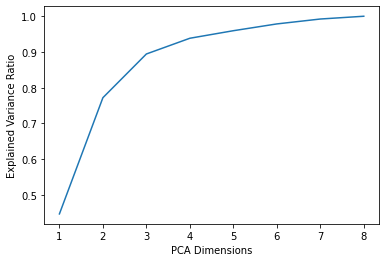

In [15]:
# Plot explained variance ratio vs number of dimensions kept
# Looks like 4 dims is appropriate. 5 dims is too high given our data set.
plt.plot(range(1,9),explained_variance)
plt.xticks(np.arange(1, 9))
plt.xlabel('PCA Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.savefig('pca_expl_var.png')

In [16]:
# Reduce to 4 dims
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_full_std)
pd.DataFrame(X_pca).describe()

,0,1,2,3
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,-2.920039e-17,-1.946692e-17,-1.338351e-17,1.946692e-17
std,1.803460e+00,1.539534e+00,9.442050e-01,5.664128e-01
min,-3.766113e+00,-4.065966e+00,-3.116362e+00,-2.043205e+00
25%,-1.354070e+00,-1.002682e+00,-6.106431e-01,-3.742521e-01
50%,-1.536418e-01,-2.497768e-01,1.275309e-02,1.223948e-02
75%,9.445777e-01,7.905239e-01,5.873776e-01,3.780657e-01
max,6.139830e+00,4.875206e+00,3.598740e+00,2.361812e+00


In [17]:
# Min-max normalize the X_pca
x_min_max_scaler = MinMaxScaler()
X_pca_minmax = x_min_max_scaler.fit_transform(X_pca)
pd.DataFrame(X_pca_minmax).describe()

,0,1,2,3
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.380187,0.454746,0.464083,0.463836
std,0.182058,0.172185,0.140609,0.128584
min,0.000000,0.000000,0.000000,0.000000
25%,0.243495,0.342604,0.373147,0.378876
50%,0.364677,0.426811,0.465982,0.466614
75%,0.475542,0.543160,0.551554,0.549662
max,1.000000,1.000000,1.000000,1.000000


In [18]:
# Min-max normalize the y
y_min_max_scaler = MinMaxScaler()
y_log_min_max = y_min_max_scaler.fit_transform(np.array(y_log).reshape(-1,1))
pd.DataFrame(y_log_min_max).describe()

,0
count,1460.000000
mean,0.487659
std,0.206372
min,0.000000
25%,0.351530
50%,0.466778
75%,0.642349
max,1.000000


In [19]:
# Create ANN model for oil recov
def model_construct(n_layers, n_nodes, n_inputs):
    '''
    n_layers
    n_nodes
    n_inputs: Dims of inputs, X_train_prepared.shape[1]
    '''
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(n_nodes, activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=[n_inputs]))
    for _ in range(n_layers-1):
        model.add(tf.keras.layers.Dense(n_nodes, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
    model.add(tf.keras.layers.Dense(1))

    # Remove lr if scheduler in use?
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
                  metrics=['mse', 'mae', tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

In [20]:
# Store version info as file in directory
def get_git_revision_hash():
    return subprocess.check_output(['git', 'rev-parse', 'HEAD'])

In [21]:
# Function to train ANN model
def train_model(model,
                X,
                y,
                batch_size,
                n_layers,
                n_nodes,
                epochs,
                initial_epoch,
                log_save_dir,
                name_prefix):
    # Create Directory for Logs
    model_name = name_prefix+'_'+str(batch_size)+'_'+str(n_layers)+'_'+str(n_nodes)+'_'+str(epochs)+'_'
    logdir = log_save_dir + ".\\logs\\scalars\\" + model_name + str(
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    logdir = logdir
    if not os.path.exists(logdir):
        os.makedirs(logdir)
        print('New logdir created.')
        
    # Logs
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=logdir,
        histogram_freq=0,  # How often to log histogram visualizations
        write_graph=True,
        update_freq='epoch',
        profile_batch=0,  # set to 0. Else bug Tensorboard not show train loss.
        embeddings_freq=0,  # How often to log embedding visualizations
    )
    
    # Early stop
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', min_delta=0.001, patience=3)

    # Save Checkpoint
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=logdir,  # +'.\\{epoch:.02d}-{mse:.2f}',
        verbose=1,
        save_weights_only=False,
        monitor='mse',  # Not sure
        mode='auto',
        save_best_only=True)

    with open(logdir + '.\\version_info.txt', 'a', newline='') as file:
        file.write('model_name'+' '+str(get_git_revision_hash()) + '\n')

    # Train. History stores loss metrics per epoch
    history = model.fit(X, y, initial_epoch=initial_epoch, epochs=epochs,
                        callbacks=[tensorboard_callback, model_checkpoint_callback],
                        shuffle=True,
                        batch_size=batch_size, verbose=2)

    # Save entire model with training config
    model.save(logdir + '.\\' + model_name + '{}'.format(str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))))
    
    return model

    endTime = datetime.datetime.now()
    print('Ended at ' + str(endTime))
    print('end')

In [22]:
# Select columns and standardize them. Drop all remaining.
select_and_std=make_column_transformer((std_scaler_X,[4,5,6,8,9,10,11,12]))

In [23]:
# Custom log transformer
log_transformer = FunctionTransformer(np.log,np.exp, validate=True)

In [48]:
# Define transformation pipeline for label

label_pipe = Pipeline([
    ('log transform', log_transformer),
    #('minmax',y_min_max_scaler)
])

In [49]:
# Define transformation pipeline for features
feature_pipe = Pipeline([
    ('Select_cols_and_std',select_and_std),
    ('Iterative_impute_KNN',IterativeImputer(random_state=0, estimator=KNeighborsRegressor(n_neighbors=8))),
    ('PCA',PCA(n_components=4)),
    ('minmax',x_min_max_scaler)
])

In [50]:
# Fit transform predictor features
X_prepared=feature_pipe.fit_transform(df)
pd.DataFrame(X_prepared).describe()

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,0,1,2,3
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.380187,0.454746,0.464083,0.463836
std,0.182058,0.172185,0.140609,0.128584
min,0.000000,0.000000,0.000000,0.000000
25%,0.243495,0.342604,0.373147,0.378876
50%,0.364677,0.426811,0.465982,0.466614
75%,0.475542,0.543160,0.551554,0.549662
max,1.000000,1.000000,1.000000,1.000000


In [51]:
# Fit transform labels
# Manually do log transform
y_prepared = label_pipe.fit_transform(np.array(y).reshape((-1,1)))
pd.DataFrame(y_prepared).describe()

,0
count,1460.000000
mean,6.752585
std,0.433915
min,5.727239
25%,6.466362
50%,6.708682
75%,7.077836
max,7.829829


In [52]:
# Inverse transform the labels
temp=pd.DataFrame(label_pipe.inverse_transform(y_prepared))
temp.describe()

,0
count,1460.000000
mean,940.976027
std,426.815580
min,307.120000
25%,643.140000
50%,819.490000
75%,1185.400000
max,2514.500000


In [53]:
# Verify inverse transform is good
y.describe()

count    1460.000000
mean      940.976027
std       426.815580
min       307.120000
25%       643.140000
50%       819.490000
75%      1185.400000
max      2514.500000
Name: Cumulative oil production (3 yr), MSTB, dtype: float64

In [38]:
# Compile ANN architecture (nodes, layers)
# Choose leaky ReLU arbitratily. Should have fast convergence.
# Search hyperparameters for best model. n_layers, n_nodes, training epochs.
n_layers=2
n_nodes=10
oilrecov3_model = model_construct(n_layers, n_nodes, X_prepared.shape[1])

In [54]:
# Train ANN. Change model name_prefix, else overwrite in same file
'''log_save_dir=r'C:\Users\win7\PycharmProjects\PGE_hack_local\logs'
name_prefix='oilrecov_log_nlayers{}_nodes{}_v0'.format(n_layers,n_nodes)
model = train_model(oilrecov3_model,
                X_prepared,
                y_prepared,
                batch_size=32,
                n_layers=n_layers,
                n_nodes=n_nodes,
                epochs=100,
                initial_epoch=0,
                log_save_dir=log_save_dir,
                name_prefix=name_prefix)'''

New logdir created.
Train on 1460 samples
Epoch 1/100

Epoch 00001: mse improved from inf to 15.50565, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039\assets
1460/1460 - 1s - loss: 15.5057 - mse: 15.5057 - mae: 3.3644 - mean_absolute_percentage_error: 49.7454
Epoch 2/100

Epoch 00002: mse improved from 15.50565 to 0.70154, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039\assets
1460/1460 - 1s - loss: 0.7015 - mse: 0.7015 - mae: 0.6588 - mean_absolute_percentage_error: 9.7818
Epoch 3/100

Ep

INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039\assets
1460/1460 - 1s - loss: 0.3054 - mse: 0.3054 - mae: 0.4376 - mean_absolute_percentage_error: 6.4948
Epoch 19/100

Epoch 00019: mse improved from 0.30539 to 0.29785, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039\assets
1460/1460 - 1s - loss: 0.2978 - mse: 0.2978 - mae: 0.4325 - mean_absolute_percentage_error: 6.4214
Epoch 20/100

Epoch 00020: mse improved from 0.29785 to 0.28938, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039
INFO:tensorflow:Assets written to: C:\Users\win7\Pycharm

Epoch 36/100

Epoch 00036: mse improved from 0.20280 to 0.19926, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039\assets
1460/1460 - 1s - loss: 0.1993 - mse: 0.1993 - mae: 0.3565 - mean_absolute_percentage_error: 5.2996
Epoch 37/100

Epoch 00037: mse improved from 0.19926 to 0.19662, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039\assets
1460/1460 - 1s - loss: 0.1966 - mse: 0.1966 - mae: 0.3552 - mean_absolute_percentage_error: 5.2987
Epoch 38/100

Epoch 00038: mse improved from 0.19662 to 

1460/1460 - 1s - loss: 0.1727 - mse: 0.1727 - mae: 0.3343 - mean_absolute_percentage_error: 4.9798
Epoch 55/100

Epoch 00055: mse improved from 0.17268 to 0.17246, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039\assets
1460/1460 - 1s - loss: 0.1725 - mse: 0.1725 - mae: 0.3341 - mean_absolute_percentage_error: 4.9755
Epoch 56/100

Epoch 00056: mse improved from 0.17246 to 0.17225, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039\assets
1460/1460 - 1s - loss: 0.1723 - mse: 0.1723 - mae: 0.333


Epoch 00096: mse did not improve from 0.17112
1460/1460 - 0s - loss: 0.1737 - mse: 0.1737 - mae: 0.3346 - mean_absolute_percentage_error: 4.9923
Epoch 97/100

Epoch 00097: mse did not improve from 0.17112
1460/1460 - 0s - loss: 0.1717 - mse: 0.1717 - mae: 0.3312 - mean_absolute_percentage_error: 4.9357
Epoch 98/100

Epoch 00098: mse did not improve from 0.17112
1460/1460 - 0s - loss: 0.1722 - mse: 0.1722 - mae: 0.3327 - mean_absolute_percentage_error: 4.9585
Epoch 99/100

Epoch 00099: mse did not improve from 0.17112
1460/1460 - 0s - loss: 0.1718 - mse: 0.1718 - mae: 0.3334 - mean_absolute_percentage_error: 4.9710
Epoch 100/100

Epoch 00100: mse did not improve from 0.17112
1460/1460 - 0s - loss: 0.1729 - mse: 0.1729 - mae: 0.3337 - mean_absolute_percentage_error: 4.9755
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-182039.\oilrecov_log_nlayers2_nodes10_v0_32_2_10_100_20210417-18

In [ ]:
# If not training, load model



In [67]:
# Load test data
preprod = pd.read_csv(r'https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/main/wellbore_data_preproduction_well.csv?token=AN5MCLHGR2P4VSYAUVKZVILAQSUVQ')


In [74]:
# Add dummy columns, because need input dims match
dummy=pd.DataFrame(np.zeros((preprod.shape[0],19-preprod.shape[1])))
X_test = pd.concat([preprod, dummy],axis=1)


In [69]:
preprod.shape

(200, 13)

In [75]:
# Transform features
X_test_prepared=feature_pipe.transform(X_test)

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [80]:
# Predict
y_test_inv= model.predict(X_test_prepared)

In [81]:
# Inverse transform lable pipeline
y_test = label_pipe.inverse_transform(y_test_inv)

In [100]:
preprod['Predicted 3 yr Oil Recovery, MTSB'] = y_test
preprod.iloc[:,[0,-1]].to_csv('Predicted_3yr_oil_recov_per_depth_and_well.csv')
preprod.head()

,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg/s-m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa","Predicted 3 yr Oil Recovery, MTSB"
0,Well_no_74,7925,5525,3050.51,NaN,NaN,7842692.077,Sandy shale,NaN,3387.576377,NaN,1646.603549,6.229941,731.760132
1,Well_no_74,7925,5525,3051.01,0.09096,NaN,7807355.262,Shaly sandstone,1.872982,NaN,NaN,1465.051728,4.930174,641.363464
2,Well_no_74,7925,5525,3051.51,0.05878,NaN,7864859.402,Sandy shale,3.187123,2660.306664,18.875428,1570.481116,7.202703,762.730469
3,Well_no_74,7925,5525,3052.01,NaN,NaN,7309508.797,Shaly sandstone,2.058578,3285.615950,26.992396,1652.096739,6.486131,869.037231
4,Well_no_74,7925,5525,3052.51,0.12285,NaN,7328552.658,Shaly sandstone,1.678339,4432.429019,35.261378,1697.320552,3.802001,745.083496


In [96]:
# Group predictions by Well_ID
preprod.groupby('Well_ID').agg('mean').iloc[:,-1].to_csv('mean_predicted_3yr_oil_recov_per_well.csv')

In [105]:
preprod.groupby('Well_ID').describe().iloc[:,-8:]#to_csv('Stats_on_pred.csv')

Predicted 3 yr Oil Recovery, MTSB                          \
                                       count        mean         std   
Well_ID                                                                
Well_no_74                              20.0  818.677002   86.430229   
Well_no_75                              20.0  798.543762  119.100510   
Well_no_76                              20.0  864.258667  137.129410   
Well_no_77                              20.0  896.663086   98.117081   
Well_no_78                              20.0  839.256470  136.666412   
Well_no_79                              20.0  867.424133  142.406158   
Well_no_80                              20.0  844.843933  109.624107   
Well_no_81                              20.0  790.041260   98.753067   
Well_no_82                              20.0  867.469849   89.885406   
Well_no_83                              20.0  823.956848  114.469597   

                                                                         
                   min         25%         50%         75%          max  
Well_ID                                                                  
Well_no_74  641.363464  758.318726  813.458069  869.981491  1023.097595  
Well_no_75  574.811462  762.346161  831.781830  871.543503   939.444946  
Well_no_76  630.349731  783.404953  863.138000  979.447510  1100.499023  
Well_no_77  729.292480  836.498932  905.196533  957.826813  1079.236084  
Well_no_78  546.071106  803.172867  873.630554  915.769211  1058.270996  
Well_no_79  583.453735  817.325775  885.884949  938.868988  1145.185669  
Well_no_80  642.018616  736.220047  839.200836  937.682968  1004.672546  
Well_no_81  596.585999  729.143692  811.801331  848.599823   979.866028  
Well_no_82  764.756409  807.372040  846.677521  901.611160  1049.670532  
Well_no_83  570.935181  796.473007  841.162598  865.700897   985.962769

In [ ]:
pd.DataFrame(X_pca).describe()

In [ ]:
# todo, log transform, then minmax? labels.

In [ ]:
# Predict
loaded_model = tf.keras.models.load_model(r'C:\Users\win7\PycharmProjects\PGE_hack_local\logs\logs\scalars\oilrecov_norm_nlayers4_nodes10_v0_32_4_10_500_20210417-132150')